
Reading --> conn_sample.parq , SampleData: True 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2269436 entries, 0 to 2269435
Data columns (total 4 columns):
 #   Column     Dtype         
---  ------     -----         
 0   ts         datetime64[ns]
 1   id_orig_h  object        
 2   id_resp_p  int64         
 3   duration   float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 69.3+ MB
None

 Not http ports: 
                               id_orig_h  id_resp_p  duration
ts                                                           
2012-03-16 06:30:00.090   192.168.202.79        443      0.01
2012-03-16 06:30:00.180   192.168.202.79        443      0.01
2012-03-16 06:30:00.270   192.168.202.79        443      0.02
2012-03-16 06:30:00.340   192.168.202.79        443      0.01
2012-03-16 06:30:00.420  192.168.202.100      16766      0.00
...                                  ...        ...       ...
2012-03-17 14:59:45.510   192.168.202.79      495

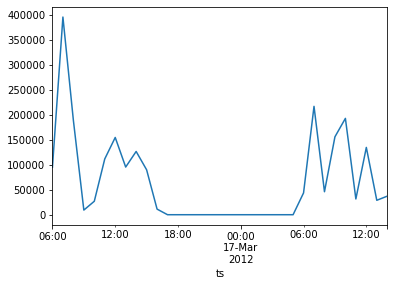


 Long duration connections: 
                                  id_orig_h  id_resp_p     duration
ts                                                                 
2012-03-17 12:23:46.960000   192.168.202.91        443  9299.670000
2012-03-17 06:47:51.890000  192.168.202.140       5432  7190.320000
2012-03-16 13:46:23.790000   192.168.202.76        427  6020.460000
2012-03-16 13:46:22.660000  192.168.202.118       1046  5964.480000
2012-03-16 14:11:17.430000   192.168.202.91        443  4499.930000
...                                     ...        ...          ...
2012-03-16 14:22:43.219999   192.168.203.45         53     5.000001
2012-03-16 13:46:52.459999   192.168.203.64         53     5.000001
2012-03-16 13:46:45.019999  192.168.202.103         53     5.000001
2012-03-16 14:25:46.699999   192.168.202.87         53     5.000001
2012-03-16 15:59:59.899999   192.168.202.87         53     5.000001

[8657 rows x 3 columns]


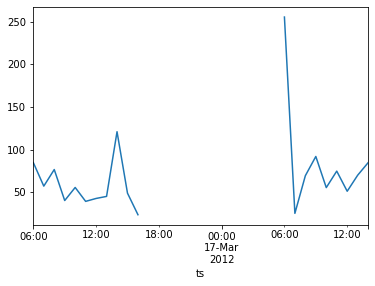


Tiempo del proceso ---> 4.01s


In [1]:
from pandas import DataFrame, read_parquet, read_csv
import matplotlib.pyplot as plt
from datetime import datetime as dt
import numpy as np
from pprint import pprint
from time import time
from os import listdir
import sys

def log_to_parquet(in_file: str, out_file: str, file_cols: list, parquet_engine: str):
    # LOAD DATA FROM A LOG FILE AND SAVE IT ON A PARQUET FILE TO IMPROVE PERFORMANCE AT READING THE DATA
    df = read_csv(in_file, sep="\t", header=None,
                  names=file_cols, low_memory=False)
    df.to_parquet(out_file, index=False, engine=parquet_engine)
    del df


def get_files_inFolder(folder: str, fileType: str):
    return list(filter(lambda fileName: 
                            fileName[-len(fileType):] == fileType,
                        listdir(folder)))
                        
#---------------------------------------------------------------------------------------------
def conn_analysis(log_file: str, sample_data: bool):
    list_log_files = get_files_inFolder("./","log")
    list_parq_files = get_files_inFolder("./","parq")
    complete_name_f = log_file.split('.log')[0]+'.parq'
    sample_name_f = log_file.split('.log')[0]+'_sample.parq'
    P_ENGINE = "pyarrow"
    SAMPLE_SIZE = 0.10
    df = None
    if not complete_name_f in list_parq_files:
        if not log_file in list_log_files:
            print("ERROR fileNotFound: "+log_file)
            return 
        try:
            log_col_names = ["ts", "uid", "id_orig_h", "id_orig_p", "id_resp_h", "id_resp_p", "proto", "service", "duration", "orig_bytes", "resp_bytes",
                            "conn_state", "local_orig", "missed_bytes", "history", "orig_pkts", "orig_ip_bytes", "resp_pkts", "resp_ip_bytes", "tunnel_parents"]
            log_to_parquet(in_file=log_file, out_file=complete_name_f,
                            file_cols=log_col_names, parquet_engine=P_ENGINE)
        except Exception as e:
            print(e)
            return
    if sample_data and (not sample_name_f in list_parq_files):
        complete_df = read_parquet(complete_name_f, engine=P_ENGINE)
        # sample_df = get_random_sample_data(complete_df, SAMPLE_SIZE)
        sample_df = complete_df.sample(frac=SAMPLE_SIZE)
        del complete_df
        sample_df.to_parquet(sample_name_f, index=False, engine=P_ENGINE)
        del sample_df

    important_cols = ["ts","id_orig_h", "id_resp_p", "duration"]
    to_read_file = sample_name_f if sample_data else complete_name_f
    print("\nReading -->",to_read_file,", SampleData:",sample_data,"\n")
    df = read_parquet(to_read_file, columns=important_cols)

    df = df[important_cols]
    df["ts"] = list(map(
        lambda date: 
            dt.fromtimestamp(float(date)),
        df["ts"].tolist()))
    df["duration"] = list(map(
        lambda dur: 
            float(dur) if not '-' in dur else 0.0,
        df["duration"].tolist()))
    print(df.info())
#---------------------------------------------------------------------------------------------
    df_not_web_port = df[(df["id_resp_p"] != 80) &
                         (df["id_resp_p"] != 8080)]
    df_not_web_port.set_index("ts",inplace=True)
    df_not_web_port = df_not_web_port.sort_index()
    print('\n', "Not http ports: ")
    pprint(df_not_web_port)
#---------------------------------------------------------------------------------------------
    df_gp_not_web_port = df_not_web_port.groupby(
        important_cols[1:3]).size().to_frame().reset_index()
    df_gp_not_web_port.rename(columns={0: "count"}, inplace=True)
    df_gp_not_web_port.sort_values(by="count", ascending=False, inplace=True)
    
    print('\n', "Not http ports count: ")
    pprint(df_gp_not_web_port)
    df_not_web_port['id_orig_h'].resample('H').count().plot()
    plt.show()
#---------------------------------------------------------------------------------------------
    df_long_conn = df[df["duration"] > 5]
    df_long_conn.set_index("ts",inplace=True)
    df_long_conn = df_long_conn.sort_index()
    df_long_conn['duration'].resample('H').mean().plot()
    df_long_conn.sort_values(by="duration", ascending=False, inplace=True)
    print('\n', "Long duration connections: ")
    pprint(df_long_conn)
    plt.show()

def main():
    intiTime = time()

    # conn_analysis(log_file="conn.log", sample_data=False)
    conn_analysis(log_file="conn.log", sample_data=True)

    elapsedTime = round(time()-intiTime, 2)
    elapsedTime = str(elapsedTime/60) + \
        "m" if elapsedTime >= 60 else str(elapsedTime)+"s"
    print("\nTiempo del proceso --->", elapsedTime)


main()
